# HoVerNet Post Processing 

In [55]:
%matplotlib widget

In [56]:
import os
import sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

In [57]:
# MODEL

from src.model.architectures.graph_construction.hover_net import HoVerNet

checkpoint_path = os.path.join(parent,"experiments","checkpoints","HoVerNet_MoNuSeg Test 4 - No Checkpoint.ckpt")
args = {"RESNET_SIZE":50, "START_LR":0}
model = HoVerNet.load_from_checkpoint(checkpoint_path,**args)

In [58]:
# TRANSFORMS
from torchvision.transforms import Compose,RandomApply
from src.transforms.image_processing.augmentation import *


scale_modes = {"image": InterpolationMode.BILINEAR, "semantic_mask": InterpolationMode.NEAREST, "instance_map": InterpolationMode.NEAREST}
transforms = Compose([


        RandomCrop(size=(64, 64)),
        Normalize(
                {"image": [0.6441, 0.4474, 0.6039]},
                {"image": [0.1892, 0.1922, 0.1535]})
        ]) 

In [59]:
# DATA

from src.datasets.MoNuSeg import MoNuSeg
val_folder=  os.path.join(parent,"data","processed","MoNuSeg_TRAIN")
dataset_val = MoNuSeg(val_folder,transform=transforms)

In [60]:
# SAMPLE
from tqdm import tqdm
sample = [dataset_val[i] for i in tqdm(range(5))]

100%|██████████| 5/5 [00:00<00:00,  8.39it/s]


In [61]:
# PREDICTIONS

model.eval()
model.cpu()
predictions = []
for item in tqdm(sample,total = len(sample)):
    sm,hv = model(item["image"].unsqueeze(0))
    sm = sm.squeeze().detach().cpu()
    hv = hv.squeeze().detach().cpu()
    predictions.append({"semantic_mask":sm,"hover_map":hv,"semantic_mask_hard":(sm>0.5).int()})


100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


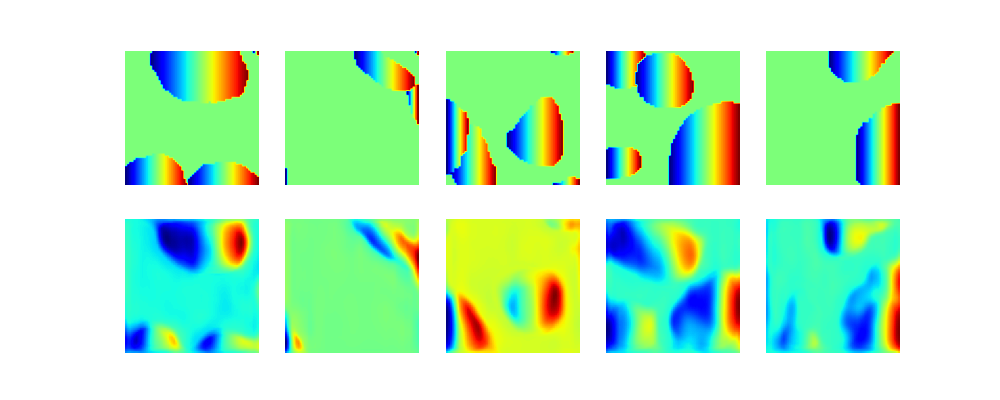

In [62]:
# DISPLAY
from src.vizualizations.image_viz import plot_images

h_maps = [img["hover_map"][0] for img in sample] + [img["hover_map"][0] for img in predictions]
plot_images(h_maps,(2,5),"jet")

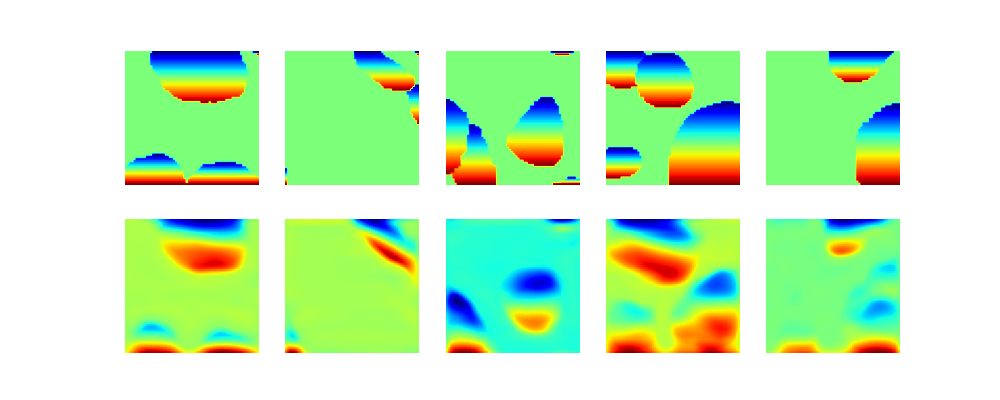

In [63]:
v_maps = [img["hover_map"][1] for img in sample] + [img["hover_map"][1] for img in predictions]
plot_images(v_maps,(2,5),"jet")

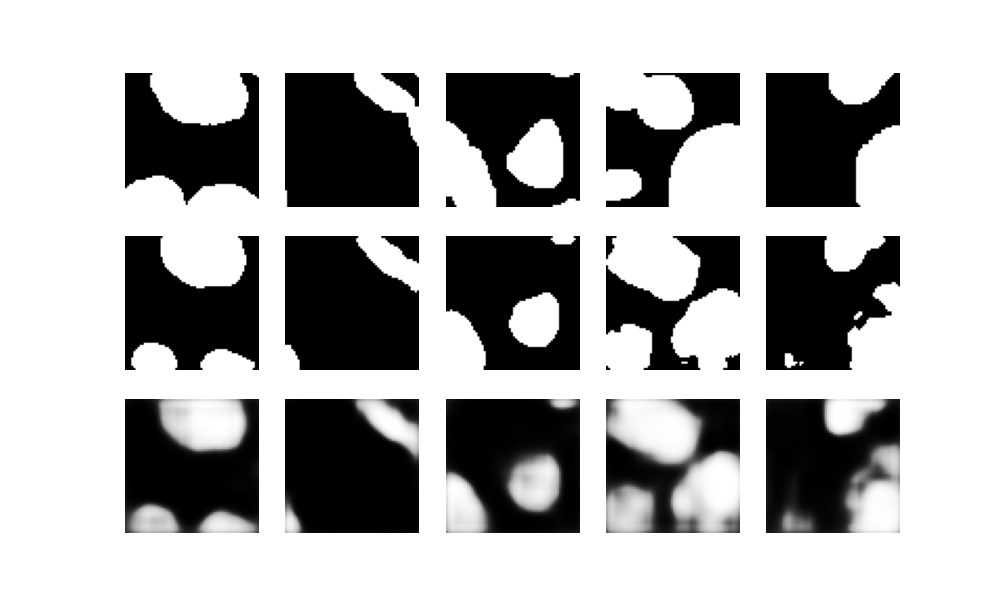

In [64]:
sms = [img["semantic_mask"].squeeze() for img in sample] + [img["semantic_mask_hard"] for img in predictions] + [img["semantic_mask"] for img in predictions]
plot_images(sms,(3,5),"gray")

# Filters

In [65]:
from PIL import ImageFilter
from torchvision.transforms import ToPILImage
from torch.nn.functional import conv2d
from torch import Tensor

sobel_x = Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]).unsqueeze(0).unsqueeze(0).float()/4
sobel_y = Tensor([[1,2,1],[0,0,0],[-1,-2,-1]]).unsqueeze(0).unsqueeze(0).float()/4

def sobel(img):
    img = img.unsqueeze(0).unsqueeze(0)
    img_x = conv2d(img,sobel_x,stride=1,padding=1)
    img_y = conv2d(img,sobel_y,stride=1,padding=1)
    return img_x,img_y

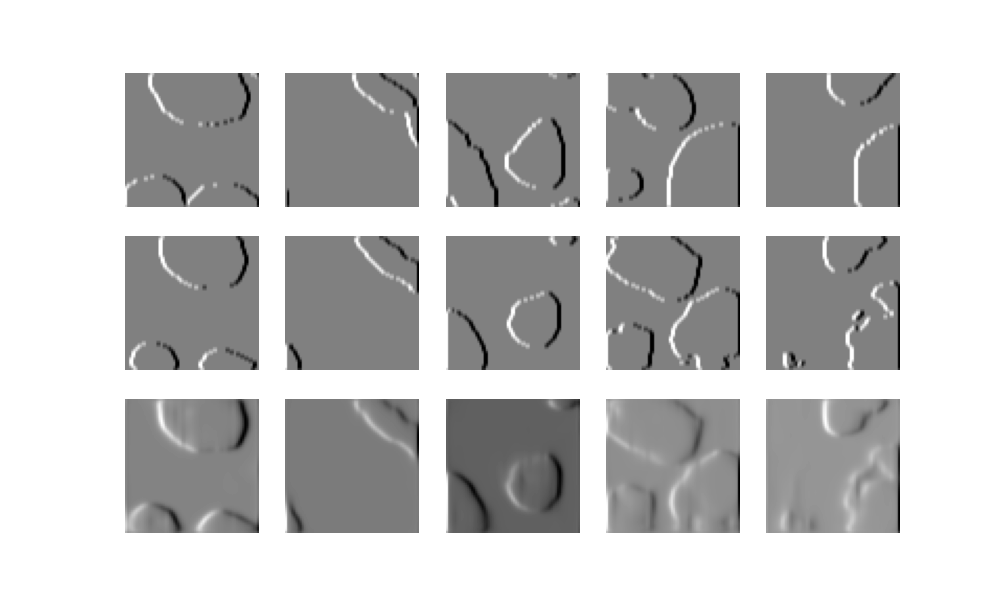

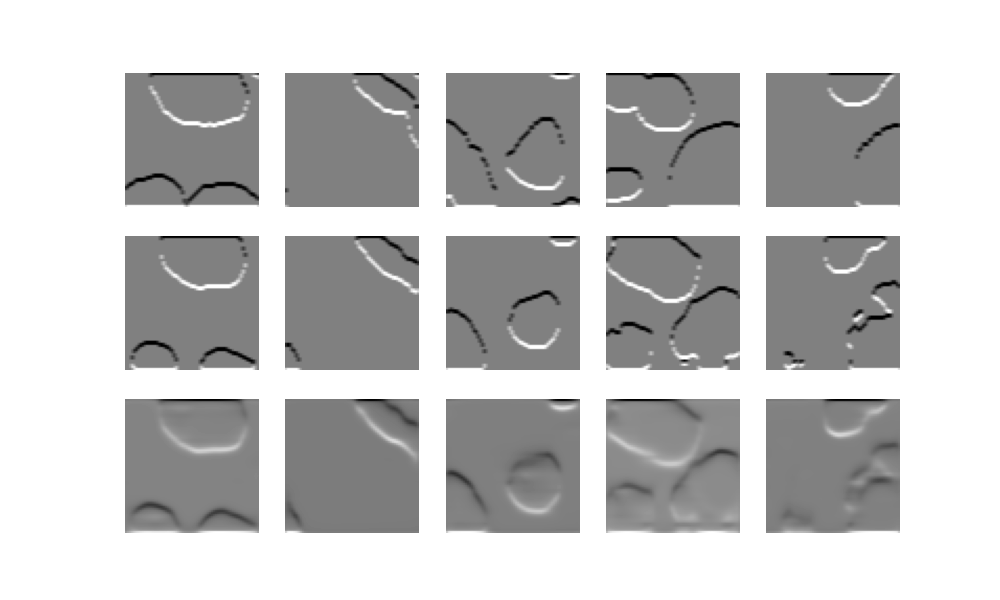

In [66]:
sms_sobel = [sobel(img.float()) for img in sms]
plot_images([img[0].squeeze() for img in sms_sobel],(3,5),"gray")
plot_images([img[1].squeeze() for img in sms_sobel],(3,5),"gray")

# TODO - NOTE THAT YOU NEED TO REALLY SPECIFY IN API USAGE


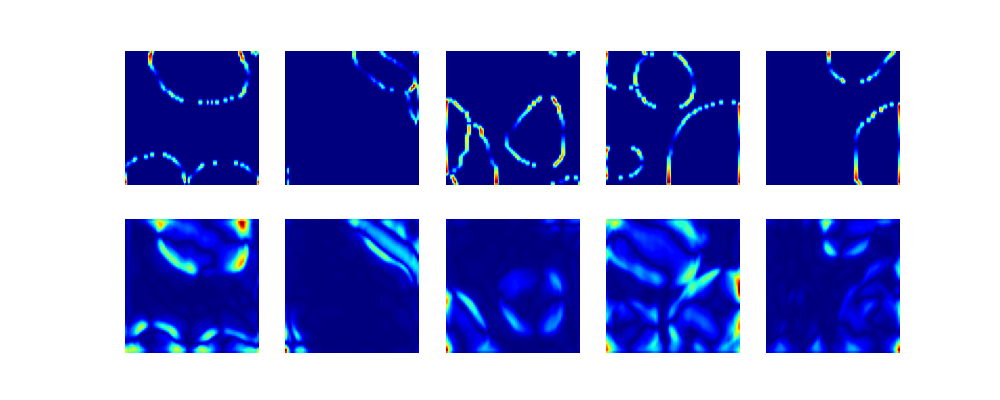

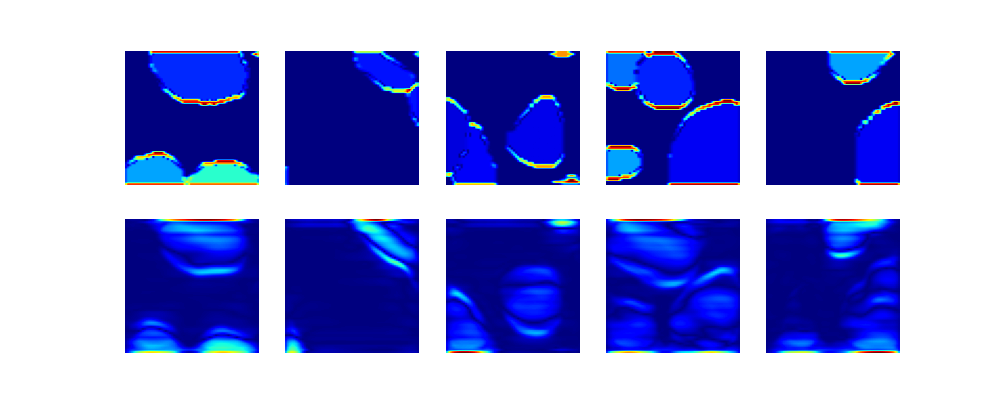

In [67]:
v_maps_sobel = [sobel(img.float()) for img in v_maps]
plot_images([img[0].squeeze().abs() for img in v_maps_sobel],(2,5),"jet")
plot_images([img[1].squeeze().abs() for img in v_maps_sobel],(2,5),"jet")

# you can see cells are 0 in first and non zero in second. This because horizontal grad perp to vertical

In [68]:
def S(hv_map):
    hv_horiz,hv_vert = hv_map
    hpx = sobel(hv_horiz.float())[0].abs()
    hpy = sobel(hv_vert.float())[1].abs()
    return torch.maximum(hpx,hpy).squeeze()

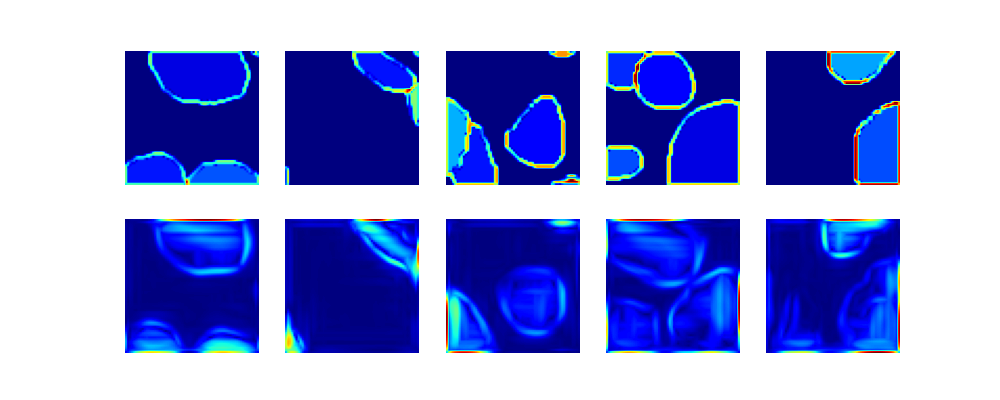

In [69]:
importance = [S(img) for img in zip(h_maps,v_maps)]
plot_images(importance,(2,5),"jet")

# Markers

In [70]:
# Hyper parameters
h = 0.5
k = 0.3

In [71]:
def M(q,Sm):
    return torch.maximum(torch.zeros_like(q),(q>h).int()-(Sm>k).int())

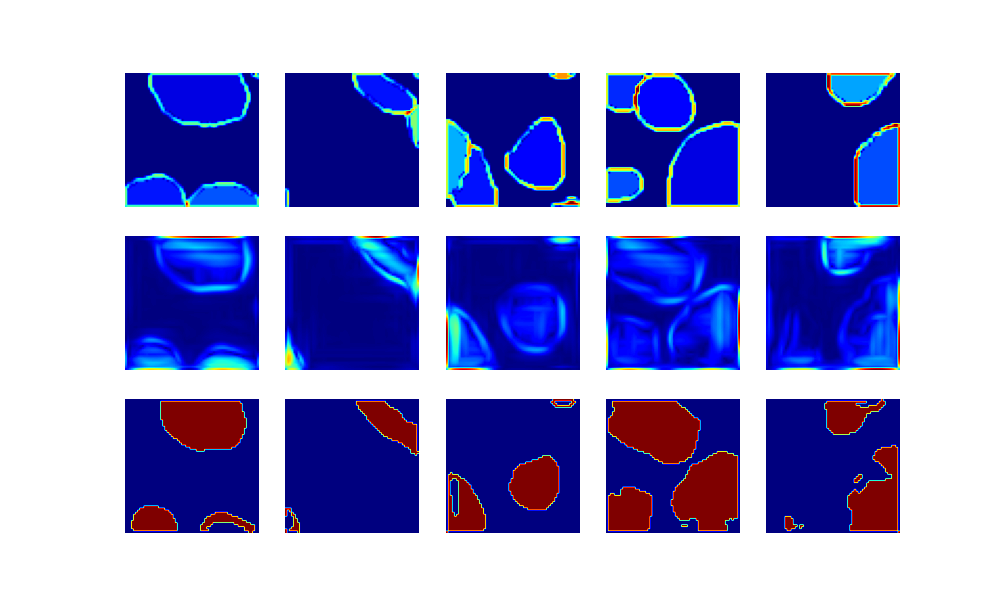

In [72]:
q_pred = sms[-5:]
Sm_pred = importance[-5:]
markers = [M(q,Sm) for q,Sm in zip(q_pred,Sm_pred)]
plot_images(importance+markers,(3,5),"jet")

# Energy Landscape

In [73]:
def E(q,Sm):
    return (1-(Sm>k).int())*(q>h).int()

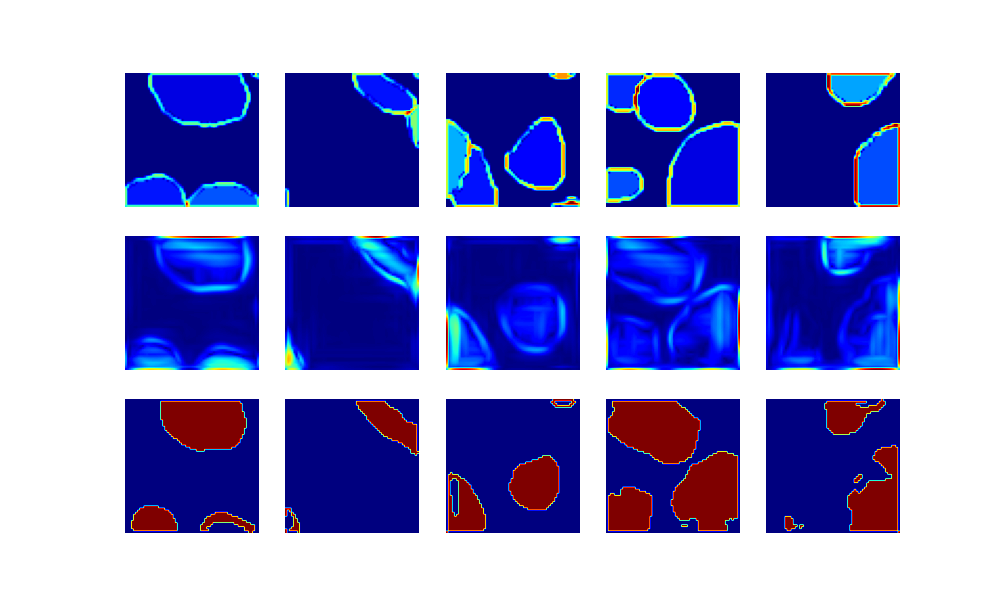

In [74]:
q_pred = sms[-5:]
Sm_pred = importance[-5:]
energy_landscape = [E(q,Sm) for q,Sm in zip(q_pred,Sm_pred)]
plot_images(importance+energy_landscape,(3,5),"jet")

# Watershedding

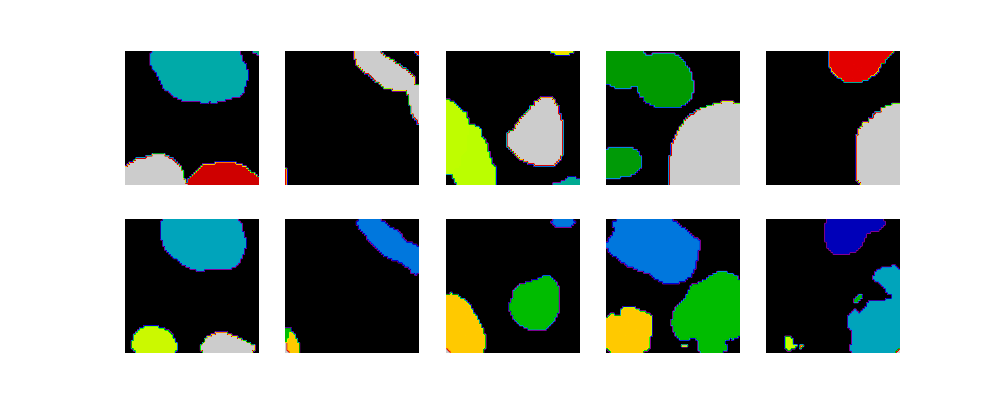

In [75]:
from skimage.segmentation import watershed
from skimage.feature.peak import peak_local_max
from scipy import ndimage
def w_shed(dist,mark,mask):
    
    lbs = ndimage.label(mark)[0]
    return watershed(-dist,markers= lbs, mask=mask) 


final_predictions = [w_shed(dist.numpy(),mark.numpy(),mask.numpy())for dist,mark,mask in zip(energy_landscape,markers,sms[5:10])]
plot_images([img["instance_mask"].squeeze() for img in sample] + final_predictions,(2,5))

# Metrics

In [88]:
from src.utilities.tensor_utilties import reset_ids
import numpy as np
from scipy.stats import mode

def IoU(img_1,img_2):
    p,s = (img_1*img_2).sum(),(img_1+img_2).sum()
    return p/(s-p)

def Panoptic_Quality(pred:np.ndarray,gt:np.ndarray):
    #TP = matched, FN = unmatched Ground Truth, FP = unmatched Predicted
    pred = reset_ids(pred)
    gt = reset_ids(gt)
    
    num_gt_cells = gt.max()
    num_pred_cells = pred.max()
    
    assignment_options = []
    
    gt_matched = set()
    pred_matched = set()
    
    TP = set()
    
    # 1) Find the predicted cell that overlaps the most with the ground truth cell
    for cell_id in range(1,num_gt_cells+1):
        gt_cell_mask = (gt==cell_id)
        mask_on_pred = (pred*gt_cell_mask)
        overlapped_ids = np.unique(mask_on_pred)
        assignment_options += [(cell_id,pred_id,IoU(gt_cell_mask.astype(np.int8),(pred==pred_id).astype(np.int8))) for pred_id in overlapped_ids if pred_id!=0]
        # (gt,pred,IoU)
    options_ranked = sorted(assignment_options,key=lambda triple: triple[2],reverse=True)

    # 2) Assign based on highest IoU (or just overlap?)
    
    for gt_id,pred_id,iou in options_ranked:
        if not(gt_id in gt_matched or pred_id in pred_matched):
            TP.add((gt_id,pred_id,iou))

    # 3) Collate into matched, unmatched gt, unmatched pred
    
    

    # 4) calculate panoptic quality
gt = sample[0]["instance_mask"]
pred = final_predictions[0]
Panoptic_Quality(pred,gt.numpy())

{(3, 3, 0.6554054054054054), (4, 2, 0.6610644257703081), (1, 1, 0.8733401430030644)}


# todos:
- [ ] Finetune h and k 
- [ ] Implement metrics and test
- [ ] Implement sliding window for re-construction of whole (metric can be on smaller)